In [36]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
import os
from tensorflow.keras.models import Sequential, load_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, pacf, acf
import pickle

In [37]:
warnings.filterwarnings("ignore")

In [38]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")

In [39]:
# Load Train Data
file_path = './rossmann-store-sales/train_data.csv'
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

In [40]:
df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,1
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,1
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,1
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,1
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,0
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,0
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,0


In [41]:
# Drop 'Customers' and 'Date' column if it exists (we don't need 'Date' and 'Customer for model prediction)
df = df.drop(columns=["Customers", "Date"], errors="ignore")

In [42]:
df

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,1,1,0,1,2015,7,31,31,1
2015-07-31,2,5,6064,1,1,0,1,2015,7,31,31,1
2015-07-31,3,5,8314,1,1,0,1,2015,7,31,31,1
2015-07-31,4,5,13995,1,1,0,1,2015,7,31,31,1
2015-07-31,5,5,4822,1,1,0,1,2015,7,31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,a,1,2013,1,1,1,0
2013-01-01,1112,2,0,0,0,a,1,2013,1,1,1,0
2013-01-01,1113,2,0,0,0,a,1,2013,1,1,1,0


In [43]:
# Separate the target ('Sales') and features (all other columns)
target = df["Sales"]
features = df.drop(columns=["Sales"])

In [44]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [45]:
# Scale the numerical features using StandardScaler
scaler = StandardScaler()
scaled_features = df[numerical_cols].copy()  # Copy the numerical columns for scaling
scaled_features = scaler.fit_transform(scaled_features)  # Scale the numerical features

In [46]:
# Replace the scaled features back into the original DataFrame
df[numerical_cols] = scaled_features

In [47]:
# Encode categorical variables using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Encode the categorical column
    label_encoders[col] = le  # Store encoder for later use


In [48]:
# Now the categorical columns have been encoded and can be used for modeling
print(df.head())

               Store  DayOfWeek     Sales      Open     Promo  StateHoliday  \
Date                                                                          
2015-07-31 -1.731640   0.501484 -0.132683  0.452399  1.273237             0   
2015-07-31 -1.728534   0.501484  0.075373  0.452399  1.273237             0   
2015-07-31 -1.725427   0.501484  0.659800  0.452399  1.273237             0   
2015-07-31 -1.722321   0.501484  2.135414  0.452399  1.273237             0   
2015-07-31 -1.719214   0.501484 -0.247231  0.452399  1.273237             0   

            SchoolHoliday      Year     Month       Day  WeekOfYear  IsHoliday  
Date                                                                            
2015-07-31       2.144211  1.502077  0.346724  1.740766    0.511626   1.156189  
2015-07-31       2.144211  1.502077  0.346724  1.740766    0.511626   1.156189  
2015-07-31       2.144211  1.502077  0.346724  1.740766    0.511626   1.156189  
2015-07-31       2.144211  1.502077  0.34

In [49]:
correlation_matrix = pd.DataFrame(scaled_features).corr()
print(correlation_matrix)

          0         1         2         3         4         5         6   \
0   1.000000 -0.000008  0.005126 -0.000047  0.000058  0.000641  0.000290   
1  -0.000008  1.000000 -0.462125 -0.528963 -0.392925 -0.205388  0.001937   
2   0.005126 -0.462125  1.000000  0.678472  0.452345  0.085124  0.023519   
3  -0.000047 -0.528963  0.678472  1.000000  0.295042  0.086171 -0.001009   
4   0.000058 -0.392925  0.452345  0.295042  1.000000  0.067483  0.024300   
5   0.000641 -0.205388  0.085124  0.086171  0.067483  1.000000 -0.036535   
6   0.000290  0.001937  0.023519 -0.001009  0.024300 -0.036535  1.000000   
7   0.001467 -0.005362  0.048768 -0.000681 -0.011747  0.103282 -0.269382   
8   0.000023  0.005136 -0.011612  0.033428 -0.108325  0.030538 -0.002485   
9   0.001421 -0.004880  0.052946  0.004792  0.000572  0.071052 -0.256619   
10 -0.000010  0.865650 -0.339044 -0.397121 -0.361974 -0.187161  0.001352   

          7         8         9         10  
0   0.001467  0.000023  0.001421 -0.000010

In [110]:
result = adfuller(target)

MemoryError: Unable to allocate 916. MiB for an array with shape (118, 1017087) and data type float64

***Check whether your time Series Data is Stationary***

In [ ]:
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is not stationary, consider differencing the data.")
else:
    print("Data is stationary")

ADF Statistic: -21.511761582345237
p-value: 0.0
Data is stationary


In [ ]:
print(len(target), len(scaled_features))

1017209 1017209


In [ ]:
# Plot PACF and ACF to decide p and q
lag_acf = acf(target, nlags=20)
lag_pacf = pacf(target, nlags=20)

In [ ]:
print(f"lag_acf : {lag_acf}")
print(f"lag_pacf : {lag_pacf}")

lag_acf : [1.         0.56547735 0.55413352 0.54861646 0.55096567 0.54863955
 0.54565831 0.56391889 0.55798695 0.54945861 0.55892516 0.57275163
 0.5555794  0.55616833 0.54955132 0.56097794 0.55600365 0.55652672
 0.55046158 0.55546228 0.54813856]
lag_pacf : [1.         0.56547791 0.34454186 0.24754408 0.2032073  0.16437364
 0.13571585 0.15550826 0.12124053 0.09137856 0.10469575 0.12220625
 0.07313484 0.07232602 0.0530116  0.07470217 0.05972429 0.05723346
 0.03840209 0.04996514 0.03217694]


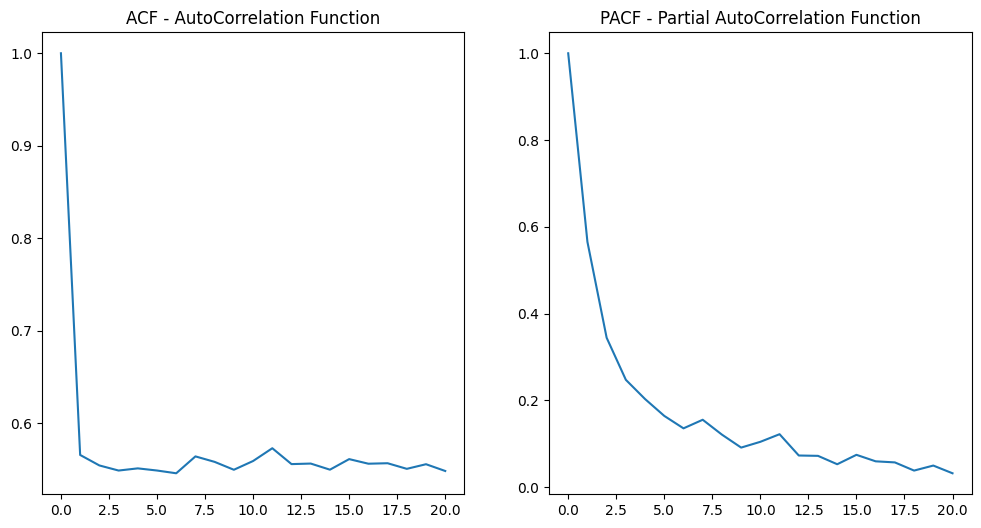

In [ ]:
# Plot ACF
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(lag_acf)
plt.title('ACF - AutoCorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.title('PACF - Partial AutoCorrelation Function')
plt.show()

In [ ]:
# Prepare the data for ARIMA
# Create the model with ARIMA using exogenous features (scaled features)
order = (2, 1, 5)  # You can tune this (p, d, q) order based on your data

In [ ]:
# Fit ARIMA model with exogenous variables
model = ARIMA(target, order=(2, 1, 5), exog=scaled_features)  # Adjust p, d, q as needed
arima_result = model.fit()

In [ ]:
# Print model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:              1017209
Model:                 ARIMA(2, 1, 5)   Log Likelihood            10776286.747
Date:                Wed, 19 Mar 2025   AIC                      -21552535.494
Time:                        22:10:21   BIC                      -21552310.675
Sample:                             0   HQIC                     -21552473.667
                            - 1017209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.352e-10   3.13e-07      0.001      0.999   -6.14e-07    6.14e-07
x2         -1.277e-09   5.64e-08     -0.023      0.982   -1.12e-07    1.09e-07
x3          3849.9243   2.28e-05   1.69e+08      0.0

In [ ]:
# Save the fitted ARIMA model using pickle
model_filename = './rossmann-store-sales/arima_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(arima_result, f)

print(f"ARIMA model saved successfully to {model_filename}")

ARIMA model saved successfully to ./rossmann-store-sales/arima_model.pkl


In [ ]:
# Save the fitted ARIMA model using pickle
model_filename = './rossmann-store-sales/arima_model.h5'
with open(model_filename, 'wb') as f:
    pickle.dump(arima_result, f)

print(f"ARIMA model saved successfully to {model_filename}")

ARIMA model saved successfully to ./rossmann-store-sales/arima_model.h5


In [ ]:
# Load the saved ARIMA model
with open('./rossmann-store-sales/arima_model.pkl', 'rb') as f:
    loaded_arima_model = pickle.load(f)

In [ ]:
# Load the saved ARIMA model
with open('./rossmann-store-sales/arima_model.h5', 'rb') as f:
    loaded_arima_model_h5 = pickle.load(f)

In [ ]:
# Use the loaded model for prediction or further operations
print(loaded_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:              1017209
Model:                 ARIMA(2, 1, 5)   Log Likelihood            10776286.747
Date:                Thu, 20 Mar 2025   AIC                      -21552535.494
Time:                        07:12:42   BIC                      -21552310.675
Sample:                             0   HQIC                     -21552473.667
                            - 1017209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.352e-10   3.13e-07      0.001      0.999   -6.14e-07    6.14e-07
x2         -1.277e-09   5.64e-08     -0.023      0.982   -1.12e-07    1.09e-07
x3          3849.9243   2.28e-05   1.69e+08      0.0

In [ ]:
arima_result

In [59]:
# In-sample predictions
y_pred_in_sample = arima_result.predict(start=0, end=len(scaled_features)-1)

In [60]:
y_pred_in_sample

Date
2015-07-31   -5.108190e+02
2015-07-31    6.064000e+03
2015-07-31    8.314000e+03
2015-07-31    1.399500e+04
2015-07-31    4.822000e+03
                  ...     
2013-01-01    1.000444e-10
2013-01-01    1.018634e-10
2013-01-01    1.009539e-10
2013-01-01    9.640644e-11
2013-01-01    9.549694e-11
Name: predicted_mean, Length: 1017209, dtype: float64

In [ ]:
# Inverse transform only the target variable (Sales) column
y_pred_in_sample = scaler.inverse_transform(y_pred_in_sample.value.reshape(-1, 1))


AttributeError: 'Series' object has no attribute 'reshape'

In [65]:
print(f"In-sample predictions: {y_pred_in_sample[:5]}")

In-sample predictions: Date
2015-07-31     -510.818972
2015-07-31     6064.000000
2015-07-31     8314.000000
2015-07-31    13995.000000
2015-07-31     4822.000000
Name: predicted_mean, dtype: float64


In [68]:
# Forecasting the next 42 days (6 weeks)
forecast_steps = 42  # 6 weeks ahead if the data is daily

In [69]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

In [72]:
# Define the columns you used during training
required_columns = ["Promo", "DayOfWeek", "StateHoliday", "SchoolHoliday", "Year", "Month", "Day", "WeekOfYear", "IsHoliday", "Open", "Store"]

In [73]:
future_exogenous_data = pd.DataFrame({
    'Promo': np.ones(42),  # Example: Assuming promo is active for the next 42 days
    'DayOfWeek': future_dates.dayofweek,  # Use the day of the week for the future dates
    'StateHoliday': np.zeros(42),  # Example: Assuming no holidays
    'SchoolHoliday': np.zeros(42),  # Example: Assuming no school holidays
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'WeekOfYear': future_dates.isocalendar().week,
    'IsHoliday': np.zeros(42),  # Example: Assuming no holidays
    'Open': np.ones(42),  # Assuming stores are open for the next 42 days
    'Store': np.ones(42)  # Assuming Store ID is constant (or modify if needed)
}, index=future_dates)

In [74]:
# Reorder the columns to match the training data columns exactly
future_exogenous_data = future_exogenous_data[required_columns]

In [85]:
future_exogenous_data.columns

Index(['Promo', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'IsHoliday', 'Open', 'Store'],
      dtype='object')

In [86]:
future_exogenous_data.dtypes

Promo            float64
DayOfWeek          int32
StateHoliday     float64
SchoolHoliday    float64
Year               int32
Month              int32
Day                int32
WeekOfYear        UInt32
IsHoliday        float64
Open             float64
Store            float64
dtype: object

In [87]:
# Separate numerical and categorical columns
numerical_cols_for_future = future_exogenous_data.select_dtypes(include=['int64', 'float64','int32','UInt32']).columns
categorical_cols_for_future = future_exogenous_data.select_dtypes(include=['object']).columns

In [89]:
numerical_cols_for_future

Index(['Promo', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'IsHoliday', 'Open', 'Store'],
      dtype='object')

In [84]:
categorical_cols_for_future

Index([], dtype='object')

In [90]:
# Scale the numerical features using StandardScaler
scaler = StandardScaler()
scaled_features_for_future = future_exogenous_data[numerical_cols_for_future].copy()  # Copy the numerical columns for scaling
scaled_features_for_future = scaler.fit_transform(scaled_features_for_future)  # Scale the numerical features

In [91]:
# Replace the scaled features back into the original DataFrame
future_exogenous_data[numerical_cols_for_future] = scaled_features_for_future

In [92]:
# Encode categorical variables using LabelEncoder
label_encoders = {}
for col in categorical_cols_for_future:
    future_exogenous_data[col] = future_exogenous_data[col].astype(str)
    le = LabelEncoder()
    future_exogenous_data[col] = le.fit_transform(future_exogenous_data[col])  # Encode the categorical column
    label_encoders[col] = le  # Store encoder for later use

In [93]:
future_exogenous_data.head(5)

,Promo,DayOfWeek,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday,Open,Store
2013-01-02,0.0,-0.5,0.0,0.0,0.0,-0.632456,-1.324037,-1.576911,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0,0.0,-0.632456,-1.210316,-1.576911,0.0,0.0,0.0
2013-01-04,0.0,0.5,0.0,0.0,0.0,-0.632456,-1.096595,-1.576911,0.0,0.0,0.0
2013-01-05,0.0,1.0,0.0,0.0,0.0,-0.632456,-0.982874,-1.576911,0.0,0.0,0.0
2013-01-06,0.0,1.5,0.0,0.0,0.0,-0.632456,-0.869153,-1.576911,0.0,0.0,0.0


In [95]:
forecast_scaled = arima_result.forecast(steps=forecast_steps, exog=future_exogenous_data)

In [103]:
forecast_scaled

1017209    5773.818972
1017210    5773.818972
1017211    5773.818972
1017212    5773.818972
1017213    5773.818972
1017214    5773.818972
1017215    5773.818972
1017216    5773.818972
1017217    5773.818972
1017218    5773.818972
1017219    5773.818972
1017220    5773.818972
1017221    5773.818972
1017222    5773.818972
1017223    5773.818972
1017224    5773.818972
1017225    5773.818972
1017226    5773.818972
1017227    5773.818972
1017228    5773.818972
1017229    5773.818972
1017230    5773.818972
1017231    5773.818972
1017232    5773.818972
1017233    5773.818972
1017234    5773.818972
1017235    5773.818972
1017236    5773.818972
1017237    5773.818972
1017238    5773.818972
1017239    5773.818972
1017240    5773.818972
1017241    5773.818972
1017242    5773.818972
1017243    5773.818972
1017244    5773.818972
1017245    5773.818972
1017246    5773.818972
1017247    5773.818972
1017248    5773.818972
1017249    5773.818972
1017250    5773.818972
Name: predicted_mean, dtype: float

In [98]:
forecast_temp = np.zeros((forecast_steps, len(df.columns) - 1))  # Exclude the target column 'Sales'
forecast_temp[:, 0] = forecast_scaled  # Set the forecasted values in the first column

In [99]:
# Reverse the scaling for the forecasted values (using the same scaler from training data)
forecast_values = scaler.inverse_transform(forecast_temp)

In [102]:
forecast_values

array([[5.77381897e+03, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.01300000e+03, 1.28571429e+00, 1.36428571e+01, 3.78571429e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77381897e+03, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.01300000e+03, 1.28571429e+00, 1.36428571e+01, 3.78571429e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77381897e+03, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.01300000e+03, 1.28571429e+00, 1.36428571e+01, 3.78571429e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77381897e+03, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.01300000e+03, 1.28571429e+00, 1.36428571e+01, 3.78571429e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77381897e+03, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.01300000e+03, 1.28571429e+00, 1.36428571e+01, 3.78571429e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [100]:
# Now you can plot the results
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

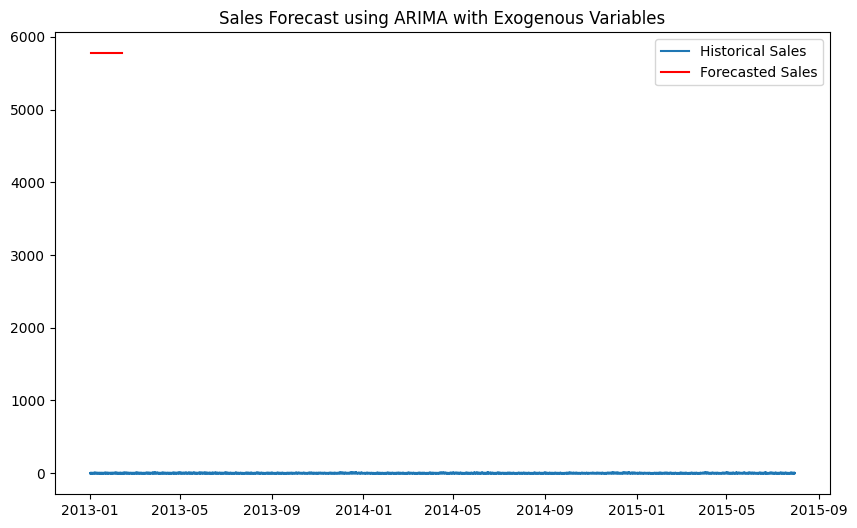

In [105]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Sales'], label='Historical Sales')  # Historical sales data
plt.plot(forecast_index, forecast_values[:, 0], label='Forecasted Sales', color='red')  # Forecasted sales
plt.legend()
plt.title('Sales Forecast using ARIMA with Exogenous Variables')
plt.show()

In [ ]:
# Inverse the scaling to get the actual forecasted values
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

In [ ]:
print(f"Forecast for the next 6 weeks (42 days): {forecast.flatten()}")

In [ ]:
import os
os.environ["MLFLOW_HTTP_REQUEST_TIMEOUT"] = "600"

In [109]:
# Log ARIMA model to MLflow
with mlflow.start_run():
    mlflow.statsmodels.log_model(arima_result, "arima_model")
    mlflow.log_param("model_order", order)

    # Forecast the next 45 days using exogenous variables
    forecast_steps = 45
    forecast = arima_result.forecast(steps=forecast_steps, exog=scaled_features[-forecast_steps:])

    # Reverse the scaling for forecasted values
    forecast_values = forecast  # As this is already predicted on the correct scale
    forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, target, label='Historical Sales')
    plt.plot(forecast_index, forecast_values, label='Forecasted Sales', color='red')
    plt.legend()
    plt.title('Sales Forecast using ARIMA with Exogenous Variables')
    plt.show()

    print("✅ ARIMA Model trained and logged to MLflow successfully!")

2025/03/20 15:09:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run delightful-snipe-99 at: http://localhost:5000/#/experiments/0/runs/279dcfb750d24a22ac22182249199c19
🧪 View experiment at: http://localhost:5000/#/experiments/0


MlflowException: API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/0/279dcfb750d24a22ac22182249199c19/artifacts/arima_model/model.statsmodels failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/0/279dcfb750d24a22ac22182249199c19/artifacts/arima_model/model.statsmodels (Caused by ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)))

---------------------------

------------------------------------

In [ ]:
# Create Sliding Window Sequences (6 Weeks = 42 Days)
def create_sequences(data, target, time_steps=42):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Use all features
        y.append(target[i + time_steps])    # Predict 'Sales'
    return np.array(X), np.array(y)

In [ ]:
time_steps = 42  # 6 weeks
X, y = create_sequences(scaled_train_data, df["Sales"].values, time_steps)

In [ ]:
# Split Data into Training & Testing (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
X_train.shape, y_train.shape

((813733, 42, 11), (813733,))

In [ ]:
X_test.shape, y_test.shape

((203434, 42, 11), (203434,))

In [ ]:
# Reshape X for LSTM (Samples, TimeSteps, Features)
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[2])

In [ ]:
# Path to Save the Model
MODEL_FILE_PATH = "./rossmann-store-sales/lstm_model_final.h5"

In [ ]:
# Check if the model already exists
if os.path.exists(MODEL_FILE_PATH):
    print("Loading previously trained model...")
    model = load_model(MODEL_FILE_PATH)  # Load the saved model